# Patrones de agentes

En mi post anterior expliqué cómo usar [LangGraph](https://www.maximofn.com/LangGraph/) para crear agentes.

Así que en este vamos a ver los diferentes patrones de agentes que podemos construir y lo haremos con LangGraph.

 > **Nota**: Vamos a partir desde el modelo más básico que consiste en un chatbot con un LLM hasta llegar a arquitecturas más complejas.

 > **Nota**: Siempre que sea posible, vamos a usar `Qwen2-72B-Instruct` para poder usarlo gratis con Hugging Face.

## Respondedor de prompts (chain block)

![chain block](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_01_chain_block.webp)

Es el modelo más básico, al LLM le entra un prompt y él devuelve una respuesta.

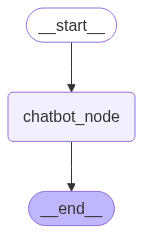

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a probarlo

In [7]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hello, how are you?")]

result = graph.invoke({"messages": messages})
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! I'm doing well, thank you for asking. How about you? How can I assist you today?


## Cadena de bloques (chain of blocks)

![chain of blocks](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_02_chain_of_blocks.webp)

Cuando una tarea se puede dividir en varias subtareas, podemos usar una cadena de bloques. Por ejemplo, si queremos resumir y traducir un texto, podemos hacerlo en dos pasos:

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import SystemMessage
from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Function
def summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

def translate(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Translate the following text to Spanish: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("summary", summary)
graph_builder.add_node("translate", translate)

# Add edges
graph_builder.add_edge(START, "summary")
graph_builder.add_edge("summary", "translate")
graph_builder.add_edge("translate", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [2]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

messages = [HumanMessage(content=text)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Large language models are advanced AI systems trained on extensive text data, enabling them to produce human-like text, translate languages, create various types of creative content, and provide informative answers to questions.
================================== Ai Message ==================================

Los modelos de lenguaje grandes son sistemas de IA avanzados entrenados con extensos datos de texto, lo que les permite producir texto similar al humano, traducir idiomas, crear diversos tipos de contenido creativo y proporcionar respuestas informativas a preguntas.


## Enrutamiento (routing)

![routing](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_03_routing.webp)

Otra cosa que podemos hacer es crear varias rutas en función del problema y elegir la que mejor se adapte a nuestro problema. Vamos a ver un ejemplo en el que el usuario puede elegir entre resumir o traducir un texto.

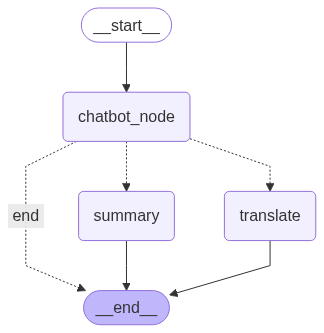

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import SystemMessage, HumanMessage
from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

def summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

def translate(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Translate the following text to Spanish: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Decision function for conditional edges
def decide_next_step(state: State) -> str:
    """
    Decides the next step after the chatbot_node.
    It checks the user's last message for keywords like 'summarize' or 'translate'.
    """
    # Filter out human messages from the state
    user_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    
    if not user_messages:
        # If there are no human messages, default to ending the process
        return "end"

    # Get the content of the last human message
    last_user_message_content = user_messages[-1].content.lower()

    if "summarize" in last_user_message_content or "resumir" in last_user_message_content:
        # If the user asked to summarize
        return "summary"
    elif "translate" in last_user_message_content or "traducir" in last_user_message_content:
        # If the user asked to translate
        return "translate"
    else:
        # Otherwise, end the process
        return "end"

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("summary", summary)
graph_builder.add_node("translate", translate)

# Add edges
graph_builder.add_edge(START, "chatbot_node")

# Add conditional edges from chatbot_node
# The decide_next_step function will determine which path to take
graph_builder.add_conditional_edges(
    "chatbot_node",         # The node where the decision is made
    decide_next_step,       # The function that makes the decision
    {                       # A dictionary mapping decision outcomes to next nodes
        "summary": "summary",   # If decide_next_step returns "summary", go to the "summary" node
        "translate": "translate", # If decide_next_step returns "translate", go to the "translate" node
        "end": END              # If decide_next_step returns "end", end the graph
    }
)

# Add edges to end the graph after summary or translate
graph_builder.add_edge("summary", END)
graph_builder.add_edge("translate", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [2]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

prompt = f"Summarize the following text: {text}"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Summarize the following text: Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Large language models are advanced AI systems trained on extensive text data, enabling them to produce human-like text, translate languages, create various types of creative content, and provide informative answers to questions.
================================== Ai Message ==================================

Large language models are sophisticated AI systems trained on vast amounts of text data, which allows them to generate human-like text, translate languages, produce creative content, and answer questions informatively.


In [3]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

prompt = f"Translate the following text to Spanish: {text}"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Translate the following text to Spanish: Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Los modelos de lenguaje grandes son sistemas de IA potentes entrenados en enormes cantidades de datos de texto. Pueden generar texto similar al humano, traducir idiomas, escribir diversos tipos de contenido creativo y responder a tus preguntas de manera informativa.
================================== Ai Message ==================================

Los grandes modelos de lenguaje son sistemas de IA potentes entrenados en enormes cantidades de datos de texto. Pueden generar texto similar al humano, traducir idiomas, escribir diversos tipos de contenido creativ

## Paralelización (parallelization)

![parallelization](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_04_paralellitation.webp)

Cuando una tarea es muy importante o compleja podemos paralelizarla para que la ejecuten diferentes LLMs. Después le pasamos el resultado a un LLM para que pueda combinarlos. Vamos a ver un ejemplo en el que tenemos tres LLMs que resumen un texto de manera diferente y luego lo combinamos.

In [19]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import SystemMessage, HumanMessage
from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    tiny_summary: str
    normal_summary: str
    extended_summary: str

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Function
def tiny_summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text in 10 words: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response], "tiny_summary": llm_response.content}

def normal_summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response], "normal_summary": llm_response.content}

def extended_summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text in 100 words: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response], "extended_summary": llm_response.content}

def aggregate(state: State):
    prompt = f"Combine the following summaries into a single one: {state['tiny_summary']}, {state['normal_summary']}, {state['extended_summary']}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("tiny_summary_node", tiny_summary)
graph_builder.add_node("normal_summary_node", normal_summary)
graph_builder.add_node("extended_summary_node", extended_summary)
graph_builder.add_node("aggregate_node", aggregate)

# Add edges
graph_builder.add_edge(START, "tiny_summary_node")
graph_builder.add_edge(START, "normal_summary_node")
graph_builder.add_edge(START, "extended_summary_node")
graph_builder.add_edge("tiny_summary_node", "aggregate_node")
graph_builder.add_edge("normal_summary_node", "aggregate_node")
graph_builder.add_edge("extended_summary_node", "aggregate_node")
graph_builder.add_edge("aggregate_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [20]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

messages = [HumanMessage(content=text)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Large language models are advanced AI systems trained on extensive text data, enabling them to produce human-like text, translate languages, create diverse content, and provide informative answers to questions. These models leverage their vast training data to understand context and generate responses that are often indistinguishable from those written by humans, making them useful in various applications such as writing, translation, and customer service.
================================== Ai Message ==================================

Large language models are advanced AI systems trained on exte

## Evaluador-optimizador (reflection pattern)

![reflection pattern](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_05_reflection_pattern.webp)

Otra manera de resolver tareas complejas es tener un LLM para resolver la tarea y otro LLM para evaluar el resultado, de manera que se ejecutan en bucle, hasta que el evaluador considera que en trabajo ha finalizado correctamente. Vamos a ver un ejemplo en el que un LLM suma 1 a un número y otro comprueba si el número es 10. 

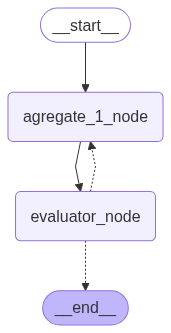

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    number: int
    evaluator: str
    
# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Function
def agregate_1(state: State):
    if state.get("number", None) is None:
        input_text = state["messages"][-1].content
        prompt = f"Get the number from the following text: {input_text}. Respond only with the number."
        number_str = llm.invoke(prompt)
        number = int(number_str.content)
        state["number"] = number
    
    number_state = state["number"]
    number_plus_1 = number_state + 1
    response = AIMessage(content=f"[Agregator] --> The number is {number_state} and the next number is {number_plus_1}")
    return {"messages": [response], "number": number_plus_1, "evaluator": "no"}

def evaluator(state: State):
    prompt = f"Is the following number {state['number']} equal to 10? Respond only with 'yes' or 'no'."
    result = llm.invoke(prompt)
    number_state = state["number"]
    response = AIMessage(content=f"[Evaluator] --> Is the following number {number_state} equal to 10? Result: {result.content}")
    return {"messages": [response], "evaluator": result.content, "number": number_state}

def decide_next_step(state: State):
    if state["evaluator"] == "yes":
        return END
    else:
        return "agregate_1_node"

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("agregate_1_node", agregate_1)
graph_builder.add_node("evaluator_node", evaluator)

# Add edges
graph_builder.add_edge(START, "agregate_1_node")
graph_builder.add_edge("agregate_1_node", "evaluator_node")
graph_builder.add_conditional_edges(
    "evaluator_node",
    decide_next_step,
    {
        "agregate_1_node": "agregate_1_node",
        END: END
    }
)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [5]:
from langchain_core.messages import HumanMessage

prompt = "Start the process with the number 1"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages}, {"number": None})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Start the process with the number 1
================================== Ai Message ==================================

[Agregator] --> The number is 1 and the next number is 2
================================== Ai Message ==================================

[Evaluator] --> Is the following number 2 equal to 10? Result: no
================================== Ai Message ==================================

[Agregator] --> The number is 2 and the next number is 3
================================== Ai Message ==================================

[Evaluator] --> Is the following number 3 equal to 10? Result: no
================================== Ai Message ==================================

[Agregator] --> The number is 3 and the next number is 4
================================== Ai Message ==================================

[Evaluator] --> Is the following number 4 equal to 10? Result: no
=====================

## Agente con herramientas (ReAct pattern)

![ReAct pattern](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_06_react_pattern.webp)

 > **Nota**: Este patrón lo voy a tener que resolver con Sonnet

Otra posibilidad es poder darle herramientas al agente

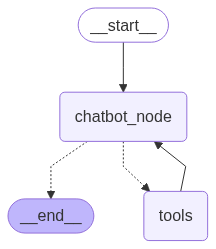

In [20]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool

from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The product of a and b.
    """
    return a * b

tools_list = [multiply]
    
# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Function
def chatbot_function(state: State):
    system_message = "You are a helpful assistant that can use tools to answer questions. Once you have the result of a tool, provide a final answer without calling more tools."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [21]:
from langchain_core.messages import HumanMessage

prompt = "Multiply 2 and 3"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages}, {"number": None})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'text': "I'll calculate the product of 2 and 3 for you using the multiply function.", 'type': 'text'}, {'id': 'toolu_01BEDxEjrJX51kGLfYENBEot', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01BEDxEjrJX51kGLfYENBEot)
 Call ID: toolu_01BEDxEjrJX51kGLfYENBEot
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


## Planning pattern

![planning pattern](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_07_planning_pattern.webp)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool

from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The product of a and b.
    """
    return a * b

tools_list = [multiply]
    
# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Function
def chatbot_function(state: State):
    system_message = "You are a helpful assistant that can use tools to answer questions. Once you have the result of a tool, provide a final answer without calling more tools."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [ ]:
from langchain_core.messages import HumanMessage

prompt = "Multiply 2 and 3"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages}, {"number": None})

for message in result["messages"]:
    message.pretty_print()

## Multi agent pattern

![multi agent pattern](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/agent_patterns_08_multi_agent_pattern.webp)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool

from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class Task(TypedDict):
    task_id: int
    task_description: str
    task_assigned_to: str

class Plan(TypedDict):
    plan_goal: str
    plan_steps: list[Task]
    
# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def planner_function(plan: Plan):
    system_message = "You are a planner that can plan tasks for a team. You will be given a goal and a list of tasks. You will need to plan the tasks for the team."
    messages = [SystemMessage(content=system_message)] + [HumanMessage(content=plan)]
    return {"messages": [llm.invoke(messages)]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [ ]:
from langchain_core.messages import HumanMessage

prompt = "Multiply 2 and 3"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages}, {"number": None})

for message in result["messages"]:
    message.pretty_print()